# MVP: Data Science & Analytics - PUC-Rio
#### Autor: Rafael Hasslocher

#### Descrição

Para esse MVP, utilizou-se uma base do Kaggle referente aos dados de poluição ao longo do tempo de um determinado conjunto de dados de treino (link: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate). Com o

O objetivo principal é realizar o ajuste com a base de treino e confrontar os resultados com a base de teste a partir de duas abordagens:

- Ajuste de um modelo ARIMA clássico;
- Ajuste de um modelo LSTM.

Ao final do trabalho, verificaremos a abordagem de melhor ajuste, contemplando as vantagens e desvantagens de suas aplicações.


### Bloco 0 - Definição das funções úteis ao longo do projeto

In [1]:
import warnings
from itertools import product
from typing import TypedDict

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import LSTM, Dense, Dropout  # type: ignore
from keras.models import Sequential, load_model  # type: ignore
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
from tensorflow.keras.metrics import RootMeanSquaredError  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore


def plot_summary_serie(df, coluna_serie, coluna_tempo, periodicidade, summary):
    df = df.resample(periodicidade)[coluna_serie].apply(summary).reset_index()
    df.set_index(coluna_tempo, inplace=True)

    plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    grafico_summary = sns.lineplot(x=df.index, y=df[coluna_serie])

    summary_name = str(summary.__name__)

    grafico_summary.set_title(
        f"Sumarização considerando a função {summary_name} e periodicidade {periodicidade}"
    )

    plt.show()


def gera_boxplot(df, coluna_serie, index):
    boxplot = plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    ax = boxplot.add_subplot(111)

    plot = sns.boxplot(
        x=index,
        y=df[coluna_serie],
        ax=ax,
        hue=index,
        palette="GnBu",
        legend=False,
    )

    plot.set_title("Box-plot da poluição anual", fontsize=15)
    plot.set_xlabel("Ano", fontsize=10)
    plot.set_ylabel("Poluição", fontsize=10)  # noqa: E703
    plot.tick_params(axis="x", labelsize=8)
    plot.tick_params(axis="y", labelsize=8)

    plt.show()


def gera_acf_pacf(df, coluna_serie, lags, tipo):
    if tipo == "acf":
        acf_values = acf(df[coluna_serie], nlags=lags)
        plot_acf(df[coluna_serie], lags=lags)
        plt.title("Gráfico de Autocorrelação")
        plt.tick_params(labelsize=7)

        plt.ylim(bottom=min(0, min(acf_values)), top=max(acf_values))
    else:
        pacf_values = pacf(df[coluna_serie], nlags=lags)
        plot_pacf(df[coluna_serie], lags=lags)
        plt.title("Gráfico de Autocorrelação parcial")
        plt.tick_params(labelsize=7)

        plt.ylim(bottom=min(0, min(pacf_values)), top=max(pacf_values))

    plt.gcf().set_facecolor("whitesmoke")
    plt.show()


def count_warnings(warnings_list):
    tipos_warnings = {}
    for warn in warnings_list:
        tipo = type(warn.message).__name__
        if tipo in tipos_warnings:
            tipos_warnings[tipo] += 1
        else:
            tipos_warnings[tipo] = 1
    return tipos_warnings


class ModeloAjustado(TypedDict):
    model: ARIMA
    warnings: dict[str, int]


def ajustar_arima(time_series: pd.DataFrame, p: int, d: int, q: int) -> ModeloAjustado:
    with warnings.catch_warnings(record=True) as warns:
        model = ARIMA(time_series, order=(p, d, q))
        model_fit = model.fit()
    tipos_warnings = count_warnings(warns)
    return ModeloAjustado(model=model_fit, warnings=tipos_warnings)


class MetricasModelo(TypedDict):
    # pep8: nomes de variaveis são snake case (lower com underline separando)
    AIC: float
    BIC: float
    RMSE: float


def obter_metricas_modelo(modelo, time_series):
    predictions = modelo.predict(start=time_series.index[0], end=time_series.index[-1])
    rmse = root_mean_squared_error(time_series, predictions)
    return MetricasModelo(RMSE=rmse, AIC=modelo.aic, BIC=modelo.bic)


def cross_validate_arimas(p_values, d_values, q_values, time_series, split):
    resultados_resumido = {}
    params = {}

    # Considerar fazer isso fora da funcao e receber direto os params.
    for p, d, q in product(p_values, d_values, q_values):
        params[f"ARIMA({p=}, {d=}, {q=})"] = {"p": p, "d": d, "q": q}

    for name, param in params.items():
        resultados_modelo = []
        for train_index, test_index in split.split(time_series):
            train, test = time_series.iloc[train_index], time_series.iloc[test_index]

            try:
                ajuste_atual = ajustar_arima(train, param["p"], param["d"], param["q"])
            except Exception as e:
                print(
                    f"Erro ao ajustar o modelo ARIMA(p={param['p']}, d={param['d']}, {param['q']}): {e}"
                )
                continue
            metricas_atual = obter_metricas_modelo(ajuste_atual["model"], test)

            resultados_modelo.append(metricas_atual)
        tamanho = len(resultados_modelo)
        resultados_resumido[name] = {
            "p": param["p"],
            "d": param["d"],
            "q": param["q"],
            "AIC": sum([metricas["AIC"] for metricas in resultados_modelo]) / tamanho,
            "BIC": sum([metricas["BIC"] for metricas in resultados_modelo]) / tamanho,
            "RMSE": sum([metricas["RMSE"] for metricas in resultados_modelo]) / tamanho,
        }

    resultados_resumido = pd.DataFrame.from_dict(resultados_resumido, orient="index")

    print(f"O modelo de menor AIC médio é o {resultados_resumido['AIC'].idxmin()}.")
    print(f"O modelo de menor BIC médio é o {resultados_resumido['BIC'].idxmin()}.")
    print(f"O modelo de menor RMSE é o {resultados_resumido['RMSE'].idxmin()}.")

    return resultados_resumido


def gera_graficos_predict(time_series, p, d, q):
    modelo = ajustar_arima(time_series, p, d, q)
    yhat = modelo["model"].predict(
        start=time_series.index[0], end=time_series.index[-1]
    )
    plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    grafico_yhat = sns.lineplot(x=time_series.index, y=time_series, label="Real")
    sns.lineplot(x=time_series.index, y=yhat, color="red", label="Previsto")
    grafico_yhat.set_title(f"Gráfico para ARIMA({p}, {d}, {q})")
    grafico_yhat.set_xlabel("Eixo X")
    grafico_yhat.set_ylabel("Eixo Y")

    return yhat


def gera_ljungbox(time_series, p, d, q):
    ajuste = ajustar_arima(time_series, p, d, q)
    model = ajuste["model"]

    ljungbox = model.test_serial_correlation(method="ljungbox")

    print(f"\nResultados do teste de Ljung-Box para ARIMA({p}, {d}, {q}):\n")

    for lag in range(len(ljungbox[0][0])):
        p_valor = ljungbox[0][1][lag]
        print(f"Lag {lag + 1}: p-valor = {p_valor}")


def gera_diagnosticos(time_series, p, d, q):
    ajuste = ajustar_arima(time_series, p, d, q)
    model = ajuste["model"]

    tela_diagnostics = plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    model.plot_diagnostics(fig=tela_diagnostics, auto_ylims=True)

    tela_diagnostics.suptitle(f"Gráficos de diagnóstico para ARIMA({p=}, {d=}, {q=})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


def construir_modelos_LSTM(hp, y_treino):
    model = Sequential()
    
    model.add(
        LSTM(
            units=hp.Int("units_1", min_value=16, max_value=256, step=16),
            return_sequences=True,
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.4, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
        )
    )

    learning_rate = hp.Choice("learning_rate", values=[1e-5, 1e-4, 1e-3, 1e-2])

    model.add(Dense(y_treino.shape[1]))
    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[RootMeanSquaredError()],
    )
    return model


def arrays_LSTM(n_past, df, n_future):
    X = []
    y = []
    for i in range(n_past, len(df) - n_future + 1):
        X.append(df[i - n_past : i, 1 : df.shape[1]])
        y.append(df[i + n_future - 1 : i + n_future, 0])
    X, y = np.array(X), np.array(y)
    return X, y

### Bloco 1 - Leitura dos Dados

In [2]:
pd.options.display.float_format = "{:,.2f}".format

#input de dados de treino e de teste

base_treino_url = "https://raw.githubusercontent.com/rafaelhasslocher/sample_project/refs/heads/main/data/LSTM-Multivariate_pollution.csv"
base_teste_url = "https://raw.githubusercontent.com/rafaelhasslocher/sample_project/refs/heads/main/data/pollution_test_data1.csv"

base_treino = pd.read_csv(base_treino_url)

base_teste = pd.read_csv(base_teste_url)

#definição das variáveis utilizadas para o ajuste do ARIMA

coluna_serie = "pollution"
coluna_tempo = "date"

print(base_treino.head())

#definição da periodicidade da série. nesse caso, definimos a própria periodicidade do conjunto de treino (horária)

frequencia_serie = "h"

#aplicando transformações necessárias na base de treino

base_treino[coluna_tempo] = pd.to_datetime(base_treino[coluna_tempo])
base_treino.set_index(coluna_tempo, inplace=True)
base_treino = base_treino.asfreq(frequencia_serie)

#verificar as informações gerais dos dados
base_treino.describe()

                  date  pollution  dew  temp    press wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00     129.00  -16 -4.00 1,020.00      SE     1.79     0   
1  2010-01-02 01:00:00     148.00  -15 -4.00 1,020.00      SE     2.68     0   
2  2010-01-02 02:00:00     159.00  -11 -5.00 1,021.00      SE     3.57     0   
3  2010-01-02 03:00:00     181.00   -7 -5.00 1,022.00      SE     5.36     1   
4  2010-01-02 04:00:00     138.00   -7 -5.00 1,022.00      SE     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0  


,pollution,dew,temp,press,wnd_spd,snow,rain
count,"43,800.00","43,800.00","43,800.00","43,800.00","43,800.00","43,800.00","43,800.00"
mean,94.01,1.83,12.46,"1,016.45",23.89,0.05,0.20
std,92.25,14.43,12.19,10.27,50.02,0.76,1.42
min,0.00,-40.00,-19.00,991.00,0.45,0.00,0.00
25%,24.00,-10.00,2.00,"1,008.00",1.79,0.00,0.00
50%,68.00,2.00,14.00,"1,016.00",5.37,0.00,0.00
75%,132.25,15.00,23.00,"1,025.00",21.91,0.00,0.00
max,994.00,28.00,42.00,"1,046.00",585.60,27.00,36.00


A tabela acima indica que os dados da variável resposta, "pollution", apresentam considerável amplitude de valores observados, o que pode se tornar desafiador em termos de modelagem. Comportamento semelhante é verificado para as covariáveis 'dew', 'temp' e 'wnd_spd'. 

Para as covariáveis 'snow', 'press' e 'rain', as amplitudes observadas são menores.

Há também uma variável categórica nos dados, o que deverá ser considerado no ajuste do LSTM.

In [3]:
print(base_teste.head())

base_teste.describe()

   dew  temp  press wnd_dir  wnd_spd  snow  rain  pollution
0  -16     4   1027      SE     3.58     0     0        128
1  -17     5   1027      SE     7.60     0     0         77
2  -16     4   1027      SE     9.39     0     0         65
3  -16     1   1028      cv     0.89     0     0         79
4  -14     0   1028      NE     1.79     0     0         93


,dew,temp,press,wnd_spd,snow,rain,pollution
count,346.00,346.00,346.00,346.00,346.00,346.00,346.00
mean,-13.88,-0.65,"1,026.08",62.47,0.00,0.00,96.40
std,4.03,4.55,6.00,107.50,0.00,0.00,98.30
min,-27.00,-9.00,"1,011.00",0.45,0.00,0.00,0.00
25%,-16.00,-4.00,"1,022.00",2.67,0.00,0.00,14.00
50%,-14.00,-1.50,"1,027.00",7.83,0.00,0.00,63.50
75%,-11.00,2.00,"1,031.00",58.78,0.00,0.00,157.50
max,-6.00,11.00,"1,035.00",441.18,0.00,0.00,444.00


Para a base de teste, aparentemente há um alinhamento no comportamento das amplitudes das variáveis. É digno de nota, no entanto, que para essa base não foram consideradas amostras contendo a incidência de chuvas ou neve.

### Bloco 2 - Plotagem dos gráficos da série em uma periodicidade menos granular, para melhor visualização.

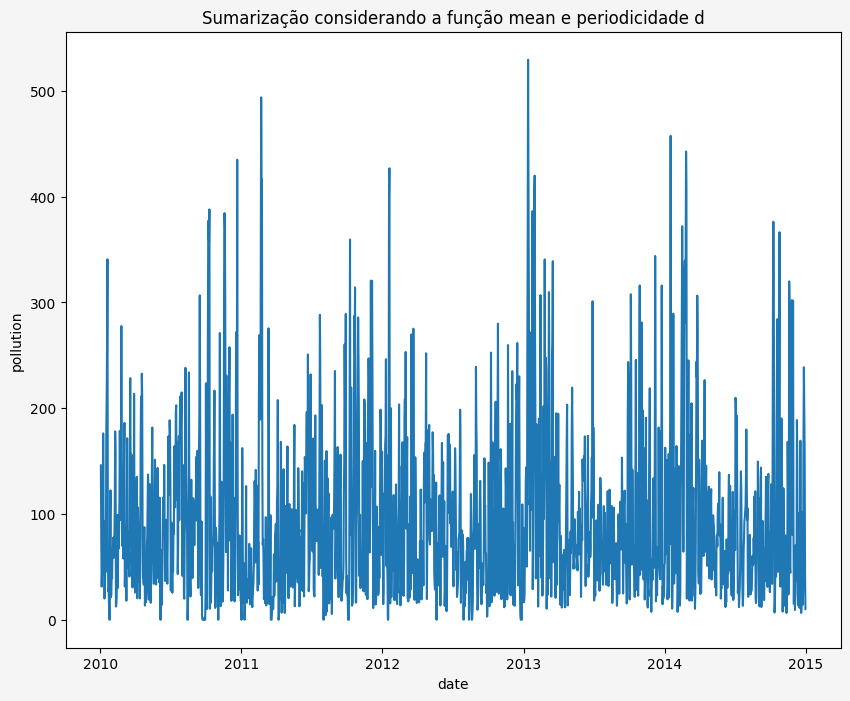

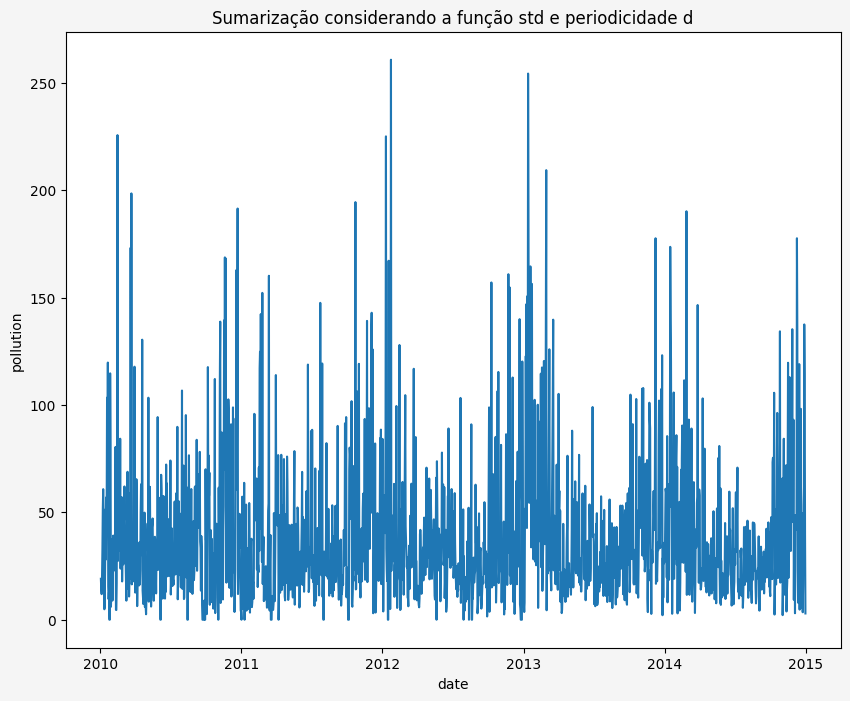

In [4]:
plot_summary_serie(base_treino, coluna_serie, coluna_tempo, periodicidade="d", summary=np.mean)
plot_summary_serie(base_treino, coluna_serie, coluna_tempo, periodicidade="d", summary=np.std)

Conforme pode ser verificado acima, a série parece ter um padrão bem estabelecido de variações periódicas ao longo dos anos tanto para a média quanto para o desvio-padrão.

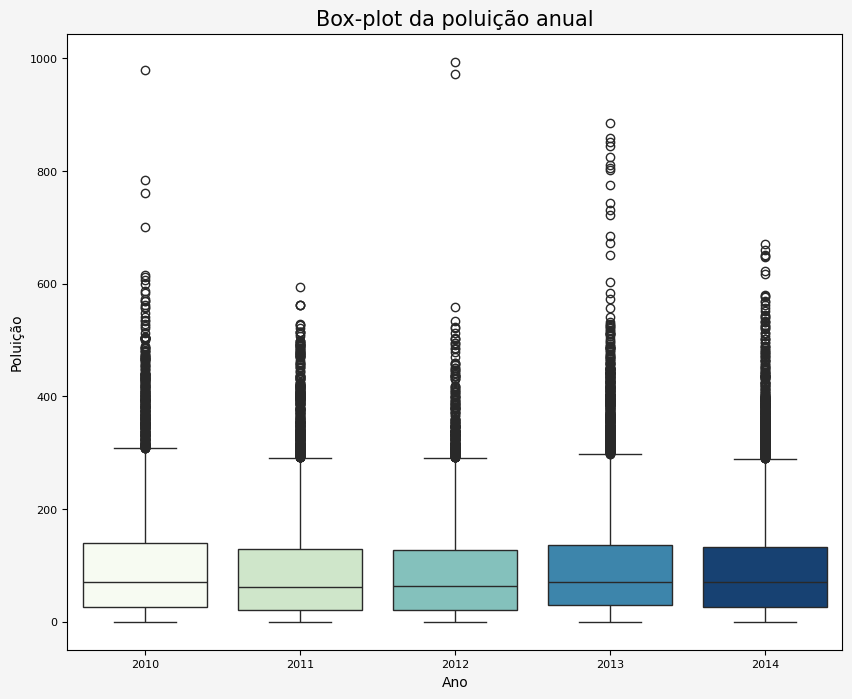

In [5]:
gera_boxplot(base_treino, coluna_serie, base_treino.index.year)

Os box-plots gerados indicam um comportamento razoavelmente constante ao longo dos anos, com similar incidência de outliers. Apesar da grande amplitude verificada anteriormente, o intervalo interquartil parece ser relativamente baixo, indicando maior concentração dos dados. A distribuição parece ser levemente assimétrica à direita.

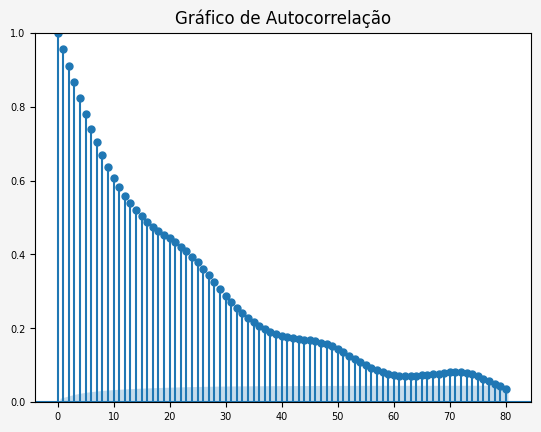

In [6]:
gera_acf_pacf(base_treino, coluna_serie, lags=80, tipo="acf")

O decaimento gradual do gráfico de autocorrelação sugere uma tendência de longo prazo na poluição. Os valores caem abaixo do intervalo de confiança aproximadamente a partir do 80º lag.

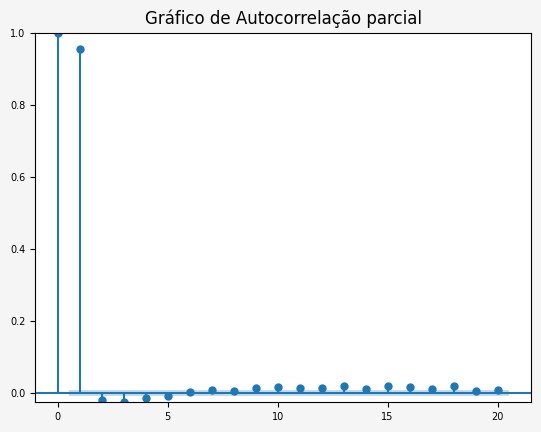

In [7]:
gera_acf_pacf(base_treino, coluna_serie, lags=20, tipo="pacf")

Para o gráfico de autocorrelação parcial, os dois primeiros lags se destacam. Em complemento ao gráfico de autocorrelação, a análise indica um componente auto-regressivo de ordem 2.

In [8]:
p_values = [1, 2, 3]
q_values = [0, 1, 2, 3]
d_values = [0]

split = TimeSeriesSplit(n_splits=2)

resultados_cv = cross_validate_arimas(p_values, d_values, q_values, base_treino[coluna_serie], split)


O modelo de menor AIC médio é o ARIMA(p=2, d=0, q=2).
O modelo de menor BIC médio é o ARIMA(p=1, d=0, q=2).
O modelo de menor RMSE é o ARIMA(p=1, d=0, q=1).


Para identificar os modelos de melhor ajuste dos dados, utilizamos a função "cross_validate_arimas" para determinar os menores valores das estatísticas AIC, BIC e RMSE. Enquanto as duas primeiras confirmam a suspeita inicial de ordem 2 para o componente auto-regressivo, a última indica melhor ajuste para a ordem 1. 

A função também traz a indicação de que há de ser considerado um componente de média móvel no modelo selecionado.

In [10]:
result = adfuller(base_treino[coluna_serie])
print("Estatística ADF", result[0])
print("p-valor", result[1])

Estatística ADF -21.004108528409155
p-valor 0.0


Para verificar a estacionariedade da série temporal, utilizamos o teste de Dickey-Fuller Aumentado (ADF). Os valores obtidos indicam uma série estacionária. 

In [30]:
p = 2
d = 0
q = 2

selecionado = ajustar_arima(base_treino[coluna_serie], p, d, q)

print(selecionado.get("warnings"))

{}


Em conjunto com a análise das funções de autocorrelação e autocorrelação parcial, selecionamos o modelo ARIMA(2, 0, 2) para ajustar os dados. O bloco acima nos indica que não houve warnings na estimação dos parâmetros do modelo, o que poderia denunciar problemas de convergência.

date
2010-01-02 00:00:00    94.01
2010-01-02 01:00:00   127.45
2010-01-02 02:00:00   145.94
2010-01-02 03:00:00   156.67
2010-01-02 04:00:00   177.89
                       ...  
2014-12-31 19:00:00    14.00
2014-12-31 20:00:00    12.06
2014-12-31 21:00:00    14.00
2014-12-31 22:00:00    14.02
2014-12-31 23:00:00    12.06
Freq: h, Name: predicted_mean, Length: 43800, dtype: float64

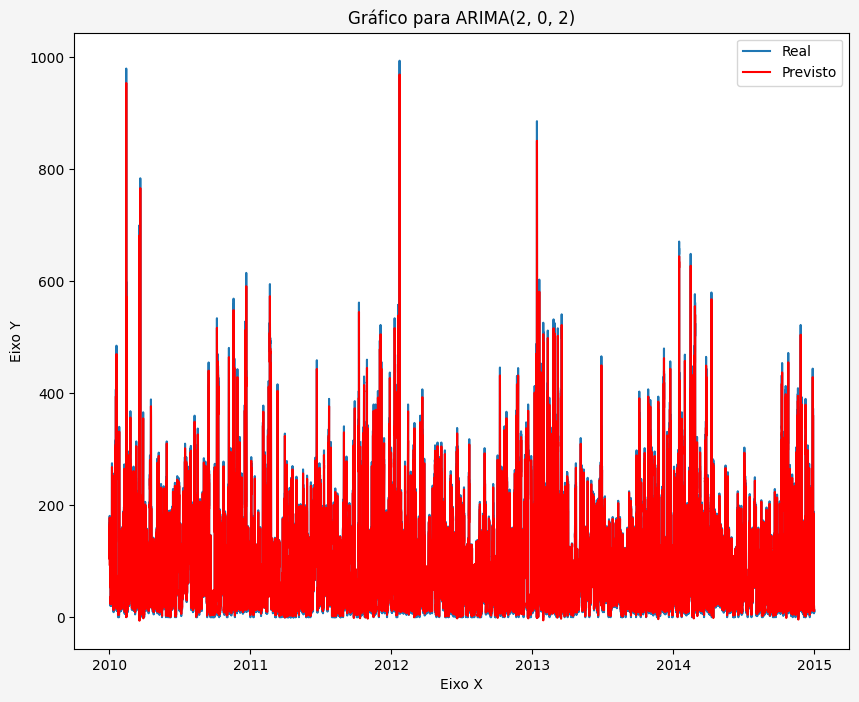

In [31]:
gera_graficos_predict(base_treino[coluna_serie], p, d, q)

O gráfico acima indica o ajuste do modelo sobre a base de treino. Podemos verificar que o ajuste parece ter sido eficiente, o que pode ser confirmado na base de teste.

In [32]:
gera_ljungbox(base_treino[coluna_serie], p, d, q)


Resultados do teste de Ljung-Box para ARIMA(2, 0, 2):

Lag 1: p-valor = 0.9987032938294931
Lag 2: p-valor = 0.9468997939209018
Lag 3: p-valor = 0.9842105257723945
Lag 4: p-valor = 0.9963904380334981
Lag 5: p-valor = 0.8353242406006214
Lag 6: p-valor = 0.48752521988467823
Lag 7: p-valor = 0.4921676127757493
Lag 8: p-valor = 0.12377544034797625
Lag 9: p-valor = 0.01037788944296152
Lag 10: p-valor = 0.005998698893349303


Com base na análise do teste de Ljung-Box, não há evidência de autocorrelação significativa para os resíduos até o lag 8, o que indica que o modelo está capturando de forma adequada a estrutura dos dados até esse ponto.

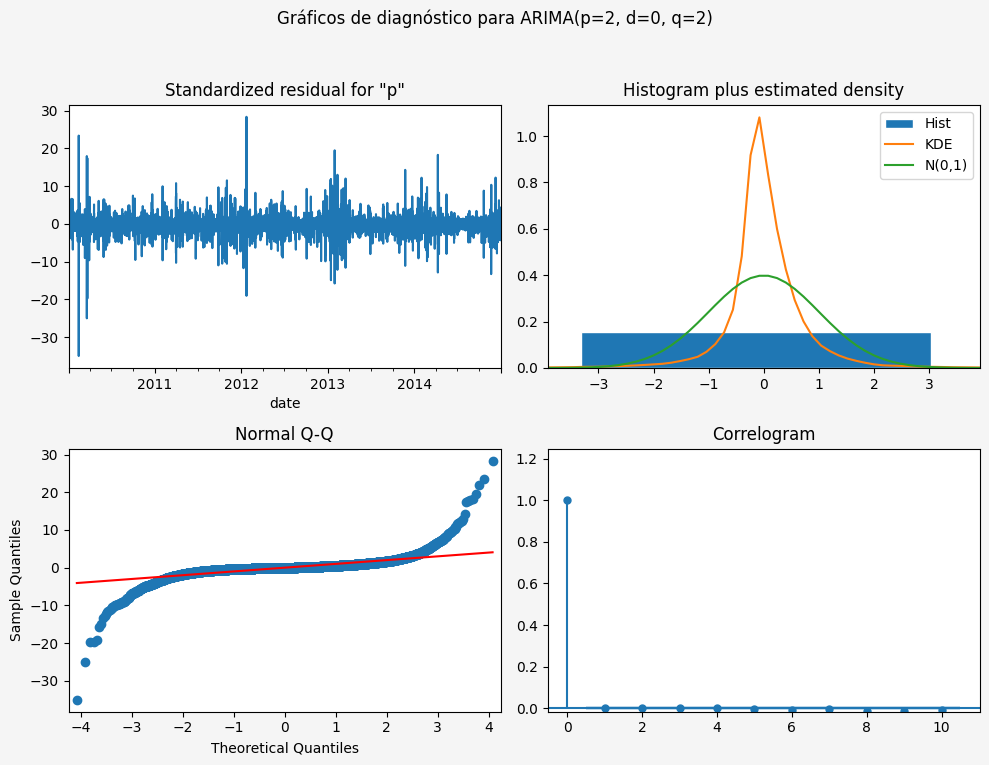

In [33]:
gera_diagnosticos(base_treino[coluna_serie], p, d, q)

O comportamento do QQ-Plot traz preocupações em relação à distribuição dos resíduos. O comportamento nas pontas do gráfico indica que pode haver desvio de normalidade. Há uma alteração significativa, também, na curtose do Kernel Density Estimate (KDE).

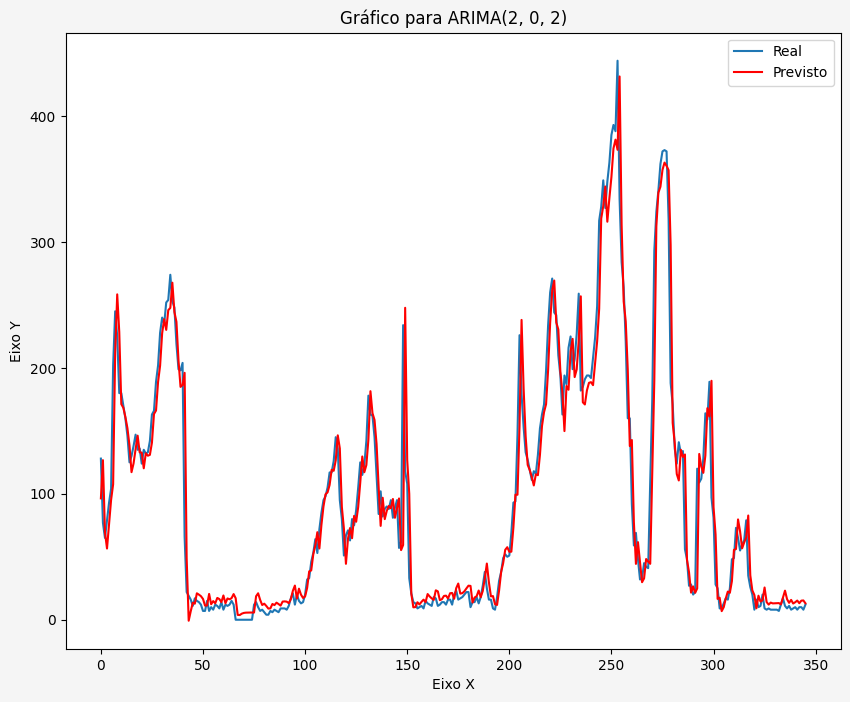

In [34]:
yhat = gera_graficos_predict(base_teste[coluna_serie], p, d, q)

Apesar dos pontos de atenção mencionados acima, o plot do gráfico traz a informação de que o modelo se ajustou muito bem aos dados de teste, com pequenos desvios em alguns períodos.

In [11]:
base_treino_encoded = base_treino.copy()
base_teste_encoded = base_teste.copy()

mapping = {"NE": 0, "SE": 1, "NW": 2, "cv": 3}

base_treino_encoded["wnd_dir"] = base_treino_encoded["wnd_dir"].map(mapping)
base_teste_encoded["wnd_dir"] = base_teste_encoded["wnd_dir"].map(mapping)

Após o ajuste do ARIMA, passamos a estar interessados no ajuste da rede neural. Para tanto, aplicamos a alteração acima na variável categórica dos dados.

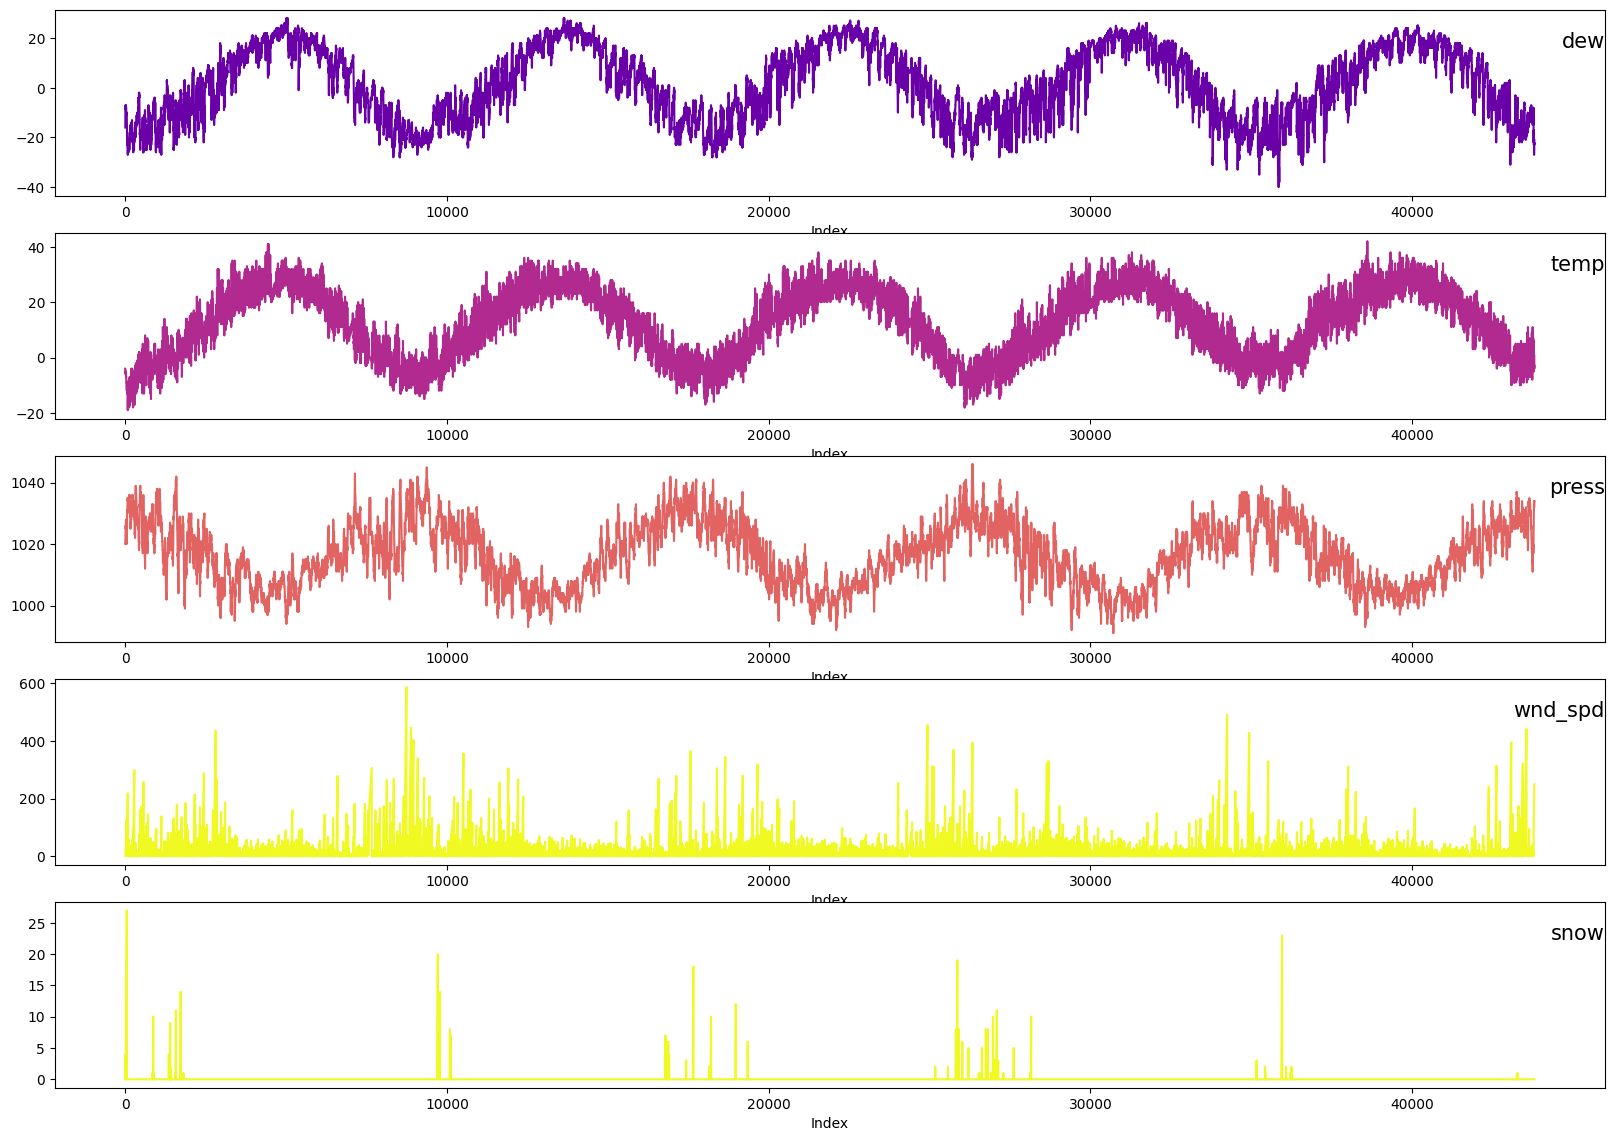

In [12]:
values = base_treino.values

groups = [1, 2, 3, 5, 6]
i = 1

plt.figure(figsize=(20, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group / len(groups)))
    plt.xlabel("Index")
    plt.title(base_treino.columns[group], y=0.75, loc="right", fontsize=15)
    i += 1
plt.show()

sns.set_theme(style="darkgrid")

O comportamento dos gráficos plotados acima indica um padrão temporal para as covariáveis 'dew', 'temp' e 'press'.

In [13]:
scaler = MinMaxScaler()

#definição das colunas a serem normalizadas
columns = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]

base_treino_encoded = base_treino_encoded[columns]
base_teste_encoded = base_teste_encoded[columns]

base_treino_encoded[columns] = scaler.fit_transform(base_treino_encoded[columns])
base_teste_encoded[columns] = scaler.transform(base_teste_encoded[columns])

base_treino_encoded.head()

base_teste_encoded.head()

base_treino_encoded = np.array(base_treino_encoded)
base_teste_encoded = np.array(base_teste_encoded)

X_treino, y_treino = arrays_LSTM(n_past=11, df=base_treino_encoded, n_future=1)

X_teste, y_teste = arrays_LSTM(n_past=11, df=base_teste_encoded, n_future=1)

print(
    "X_train shape : {}   y_train shape : {} \n"
    "X_test shape : {}      y_test shape : {} ".format(
        X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape
    )
)

X_train shape : (43789, 11, 7)   y_train shape : (43789, 1) 
X_test shape : (335, 11, 7)      y_test shape : (335, 1) 


Aplicamos a função "arrays_LSTM" para a transformação dos dados em um formato array do pacote numpy. A modificação é necessária para o ajuste do modelo LSTM.

In [14]:
# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

tuner = RandomSearch(
    lambda hp: construir_modelos_LSTM(hp, y_treino),
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="my_dir",
    project_name="lstm_tuning",
    overwrite=True,
)

tuner.search(
    X_treino,
    y_treino,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False,
)

Trial 10 Complete [00h 00m 31s]
val_loss: 0.011192267760634422

Best val_loss So Far: 0.006573065184056759
Total elapsed time: 00h 07m 46s


Aplicamos o pacote keras-tuner para a definição dos melhores hiperparâmetros para o ajuste do modelo LSTM.

In [15]:
# Obter os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters()[0]

# Visualizar os valores dos melhores hiperparâmetros
print(f"Melhor número de unidades na primeira camada LSTM: {best_hps.get('units_1')}")
print(f"Melhor taxa de dropout na primeira camada: {best_hps.get('dropout_1')}")
print(f"Melhor número de unidades na segunda camada LSTM: {best_hps.get('units_2')}")
print(f"Melhor learning rate: {best_hps.get('learning_rate')}")

model = construir_modelos_LSTM(best_hps, y_treino)
history = model.fit(
    X_treino,
    y_treino,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False,
)

model.save("best_model.keras")


Melhor número de unidades na primeira camada LSTM: 48
Melhor taxa de dropout na primeira camada: 0.30000000000000004
Melhor número de unidades na segunda camada LSTM: 40
Melhor learning rate: 0.0001
Epoch 1/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 2/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 3/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 4/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 5/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0

Com os melhores hiperparâmetros definidos, aplicamos o efetivo ajuste do modelo LSTM.

In [16]:
best_model = load_model("best_model.keras")

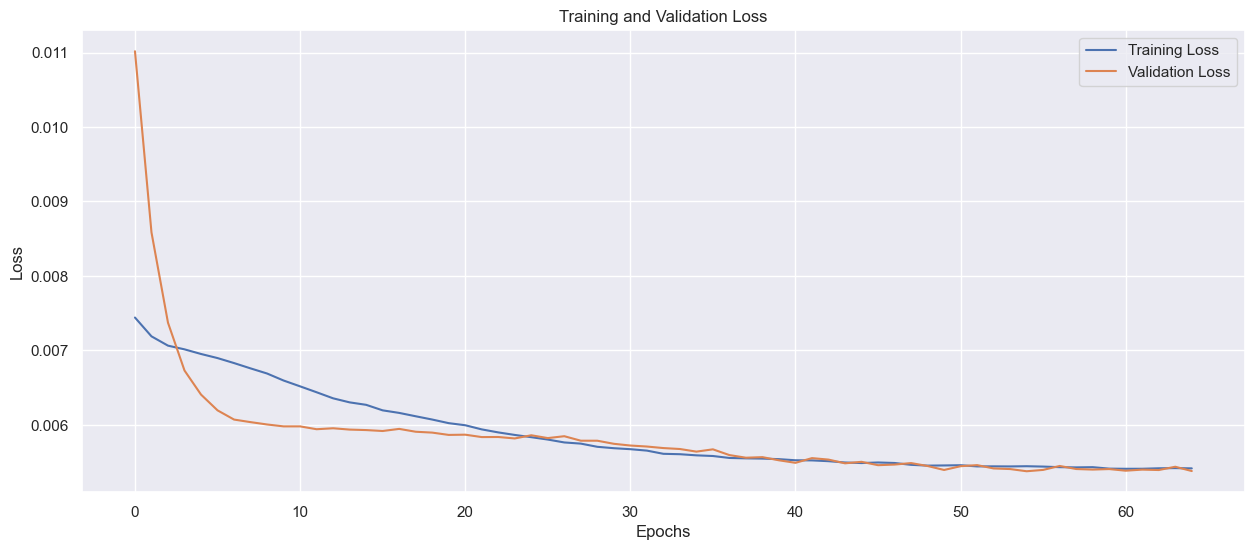

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


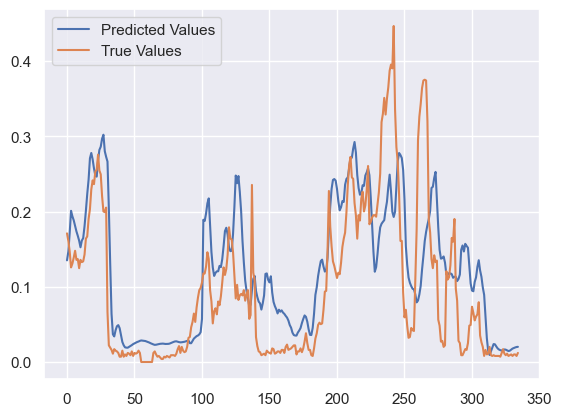

In [17]:

plt.figure(figsize=(15, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_predictions = best_model.predict(X_teste).flatten()
test_results = pd.DataFrame(
    data={"Train Predictions": test_predictions, "Actual": y_teste.flatten()}
)
test_results.head()

plt.plot(test_results["Train Predictions"], label="Predicted Values")
plt.plot(test_results["Actual"], label="True Values")
plt.legend()
plt.show()

O comportamento acima um razoável ajuste dos dados, com muitas das tendências sendo capturadas ao longo do tempo. No entanto, é possível verificar visualmente que o ajuste efetuado não performa tão bem quanto o modelo ARIMA.

Em que pese os apontamentos relacionados à normalidade dos resíduos, o modelo ARIMA apresentou melhor performance para a base de teste. É importante pontuar, no entanto, que não se trata de uma "definição final" quanto à qualidade do ajuste dos modelos, de modo que seria prudente observar o comportamento futuro dos dados de poluição e submetê-los a novos ajustes.